# 3. Introduction to TensorFlow, PyTorch, JAX, and Keras

[DLWP, Chapter 3](https://deeplearningwithpython.io/chapters/chapter03_introduction-to-ml-frameworks)

In [2]:
# @title
import os
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'plasma' # nice colours
plt.rcParams['lines.markersize'] = 2  # nice scatter point size
from IPython.core.magic import register_cell_magic

import numpy as np

os.environ["KERAS_BACKEND"] = "jax"

import keras

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

This chapter orients you in the modern deep learning ecosystem, introducing TensorFlow, PyTorch, JAX, and Keras and showing how core concepts like tensors, layers, losses, optimizers, and training loops map into each framework’s APIs. The goal is to give you enough familiarity with each tool that you can both understand code written in it and start training simple models in practice.


- [TensorFlow](https://tensorflow.org)
- [PyTorch](https://pytorch.org/)
- [JAX](https://jax.readthedocs.io/)



## A brief history of deep learning frameworks

Besides Keras, the main deep learning frameworks today are JAX, TensorFlow, and PyTorch.

All these frameworks combine three key features:
- A way to compute gradients for arbitrary differentiable functions (automatic differentiation)
- A way to run tensor computations on CPUs and GPUs (and possibly even on other specialized deep learning hardware)
- A way to distribute computation across multiple devices or multiple computers, such as multiple GPUs on one computer, or even multiple GPUs across multiple separate computers

Precursor frameworks include Theano, Torch, Caffe. In 2015, Keras launched, as well as TensorFlow. PyTorch was launched not long after, a response by Meta (it took a more object-oriented approach, as opposed to a functional, then prevalent in TF). Later on, again in response to the popularity of PyTorch, TensorFlow moved to be more object oriented. And after that, people wanting to keep the functional approach developed JAX.


## How these frameworks relate to each other

Keras, TensorFlow, PyTorch, and JAX don’t all have the same feature set and aren’t interchangeable. Keras is a **high-level framework**, while the others are **lower level**.

As you saw in the previous chapters, training a neural network revolves around the following concepts:

 - First, **low-level tensor manipulation** — The infrastructure that underlies all modern machine learning. This translates to low-level APIs found in TensorFlow, PyTorch[2], and JAX:
    - *Tensors*, including special tensors that store the network’s state (variables)
    - *Tensor operations* such as `addition`, `relu`, or `matmul`
    - *Backpropagation*, a way to compute the gradient of mathematical expressions
 - Second, **high-level deep learning concepts** — This translates to Keras APIs:
    - *Layers*, which are combined into a model
    - A *loss function*, which defines the feedback signal used for learning
    - An *optimizer*, which determines how learning proceeds
    - *Metrics* to evaluate model performance, such as accuracy
    - A *training loop* that performs mini-batch stochastic gradient descent

Further, Keras needs a **backend** engine to run (TensorFlow, PyTorch, or JAX – NumPy does not provide an autograd engine, and so cannot be used).

## Introduction to TensorFlow

In [10]:
import tensorflow as tf

### First steps with TensorFlow


Key concepts:
- Tensors and variables
- Numerical operations in TensorFlow
- Computing gradients with a GradientTape
- Making TensorFlow functions fast by using just-in-time compilation


#### Tensors and variables in TensorFlow

##### Constant tensors

In [3]:
tf.ones(shape=(2, 1))

I0000 00:00:1768396102.912747 6258555 service.cc:152] XLA service 0x16238add0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768396102.913284 6258555 service.cc:160]   StreamExecutor device (0): Host, Default Version


<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [1.]], dtype=float32)>

In [4]:
tf.zeros(shape=(2, 1))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>

In [5]:
tf.constant([1, 2, 3], dtype="float32")

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

##### Random tensors

In [6]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[-1.8983238 ]
 [ 1.0906285 ]
 [ 0.03835057]], shape=(3, 1), dtype=float32)


In [7]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.03240764]
 [0.9330411 ]
 [0.9656286 ]], shape=(3, 1), dtype=float32)


##### Tensor assignment and the Variable class

TensorFlow tensors aren’t assignable: they’re constant!

In [8]:
x = np.ones(shape=(2, 2))
x[0, 0] = 0.0

Try to do the same thing in TensorFlow: you will get an error, `EagerTensor object does not support item assignment`.

In [9]:
x = tf.ones(shape=(2, 2))
# This will fail, as a tensor isn't assignable.
x[0, 0] = 0.0

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

To create a variable, you need to provide some initial value, such as a random tensor.

In [10]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 2.2543976 ],
       [-0.64311165],
       [ 1.3868986 ]], dtype=float32)>


The state of a variable can be modified via its `assign` method.

In [11]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

In [12]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

In [13]:
v.assign_add(tf.ones((3, 1))) # or assign_sub

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

#### Tensor operations: Doing math in TensorFlow

Just a few examples:

In [14]:
a = tf.ones((2, 2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a, b)
f = tf.concat((a, b), axis=0)

Equivalent to the `Dense` layer:

In [15]:
def dense(inputs, W, b):
    return tf.nn.relu(tf.matmul(inputs, W) + b)

#### Gradients in TensorFlow: A second look at the GradientTape API

So far, this is similar to `NumPy`. The main addition of TF is to be able to compute the gradient of a series of operations:

In [16]:
input_var = tf.Variable(initial_value=3.0)
# all operations in the tape scope are recorded
with tf.GradientTape() as tape:
    result = tf.square(input_var)
gradient = tape.gradient(result, input_var)
print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


This is most commonly used to retrieve the gradients of the loss of a model with respect to its weights: `gradients = tape.gradient(loss, weights)`.

So far, you’ve only seen the case where the input tensors in `tape.gradient()` were TensorFlow variables. It’s actually possible for these inputs to be any arbitrary tensor. However, only trainable variables are being tracked by default. With a constant tensor, you’d have to manually mark it as being tracked, by calling `tape.watch()` on it. (To avoid wasting resources, the tape needs to know what to watch.)

In [ ]:
input_const = tf.constant(3.0)
with tf.GradientTape() as tape:
    # tape.watch(input_const) # uncomment to compute the gradient
    result = tf.square(input_const)
gradient = tape.gradient(result, input_const)
print(gradient)

None


The gradient tape is a powerful utility, even capable of computing **second-order gradients** — that is, the gradient of a gradient.

In [ ]:
time = tf.Variable(0.0)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position = 4.9 * time**2
    speed = inner_tape.gradient(position, time)
# We use the outer tape to compute the gradient of the gradient from
# the inner tape. Naturally, the answer is 4.9 * 2 = 9.8.
acceleration = outer_tape.gradient(speed, time)
print(acceleration)

tf.Tensor(9.8, shape=(), dtype=float32)


#### Making TensorFlow functions fast using compilation

All the TensorFlow code you’ve written so far has been executing “eagerly.” This means operations are executed one after the other in the Python runtime, much like any Python code or NumPy code. Eager execution is great for debugging, but it is typically quite slow. It can often be beneficial to parallelize some computation, or “fuse” operations — replacing two consecutive operations, with a single, more efficient operation that does the same thing without materializing the intermediate output.

This can be achieved via compilation (that rewrites operation into a faster and more efficient “compiled program”, and runs that instead).

This makes debugging more difficult, make sure you do that first!

In [20]:
# 'compile' the function
@tf.function
def dense(inputs, W, b):
    return tf.nn.relu(tf.matmul(inputs, W) + b)

TensorFlow has two compilation modes:

- First, the default one, which we refer to as “graph mode.” Any function decorated with `@tf.function` runs in graph mode.
- Second, compilation with XLA (Accelerated Linear Algebra), a high-performance compiler for ML – specify `jit_compile=True`. This is even faster, but the first run takes a bit longer.


In [21]:
@tf.function(jit_compile=True)
def dense(inputs, W, b):
    return tf.nn.relu(tf.matmul(inputs, W) + b)

### An end-to-end example: A linear classifier in pure TensorFlow

In [3]:
num_samples_per_class = 1000

# our data: two clouds of points,
# to be classified positive and negative
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class
)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class
)

In [4]:
# Plumbing: we stack the two classes into an array with shape (2000, 2)
# the first 1000 are the coordinates for negative points,
# the next 1000 are for positive points
inputs = np.vstack(
    (
        negative_samples,
        positive_samples
    )
).astype(np.float32)
print("inputs shape:", inputs.shape)
print("first five points:")
print(inputs[:5])
print()

inputs shape: (2000, 2)
first five points:
[[ 0.8520425   3.4261255 ]
 [ 0.930489    4.3757544 ]
 [ 0.45729056  1.4323674 ]
 [ 0.93764794  3.4989007 ]
 [-0.4883271   2.8486981 ]]



In [6]:
# More plumbing: we generate the corresponding targets (0 and 1)
# the first 1000 are 0, the next are 1
targets = np.vstack(
    (
        np.zeros((num_samples_per_class, 1), dtype="float32"),
        np.ones((num_samples_per_class, 1), dtype="float32")
    )
)

In [7]:
print("targets shape:", targets.shape)
print()
print("first two positive and negative data points with labels:")
print(inputs[:2])
print(targets[:2])
print()
print(inputs[1000:1002])
print(targets[1000:1002])

targets shape: (2000, 1)

first two positive and negative data points with labels:
[[0.8520425 3.4261255]
 [0.930489  4.3757544]]
[[0.]
 [0.]]

[[3.9491549 0.9539418]
 [3.5306113 1.933619 ]]
[[1.]
 [1.]]


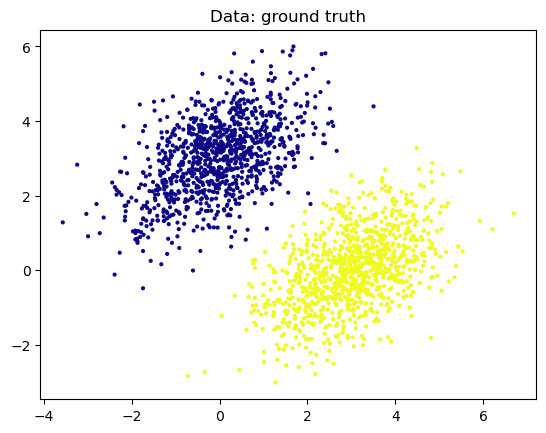

In [8]:
# Plotting the two point classes
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.title("Data: ground truth")
plt.show()

#### Creating the linear classifier variables

Our linear model is $Wx + b$ , learning a line with a slope and offset `W` is two-dimensional (x and y), `b` is one-dimensional. When we compute $Wx$, a dot product, we have two 'inputs' (x and y), 
and we end up with one 'output', that will be added to `b`.

In [27]:
input_dim = 2
output_dim = 1

# initialisation: random for W, 0 for b
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

In [28]:
print(W)
print()
print(b)

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[0.21354997],
       [0.88502777]], dtype=float32)>

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


#### The forward pass function

In [29]:
# our model, given (x, y) we compute a linear transformation and return a number
def model(inputs, W, b):
    return tf.matmul(inputs, W) + b # Wx + b

In [30]:
my_point = [[1.,2.]]
print(model(my_point, W, b))
my_other_point = [[-1.,2.]]
print(model(my_other_point, W, b))

tf.Tensor([[1.9836055]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.5565056]], shape=(1, 1), dtype=float32)


In [31]:
# we can do many points in one fell swoop!
my_vector_of_points = tf.concat([my_point, my_other_point], axis=0)
print(my_vector_of_points)
print(model(my_vector_of_points, W ,b))

tf.Tensor(
[[ 1.  2.]
 [-1.  2.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1.9836055]
 [1.5565056]], shape=(2, 1), dtype=float32)


#### The mean squared error loss function

In [32]:
# how far are we from our predictions?
# take the difference and square it (all positive)
# finally, take the average over the whole tensor
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

#### The training step function

In [33]:
learning_rate = 0.1

@tf.function(jit_compile=True)
def training_step(inputs, targets, W, b):
    # we will learn about the gradient: what this does is 
    # computing how much we need to change W and b to improve
    # performance a little bit
    with tf.GradientTape() as tape:
        # 1. We make a prediction
        predictions = model(inputs, W, b)
        # 2. We check how good we did
        loss = square_loss(targets, predictions)
    # 3. Accordingly, we compute how much
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    #    we need to tweak W and b in order
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    #    to improve performance!
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

#### The batch training loop

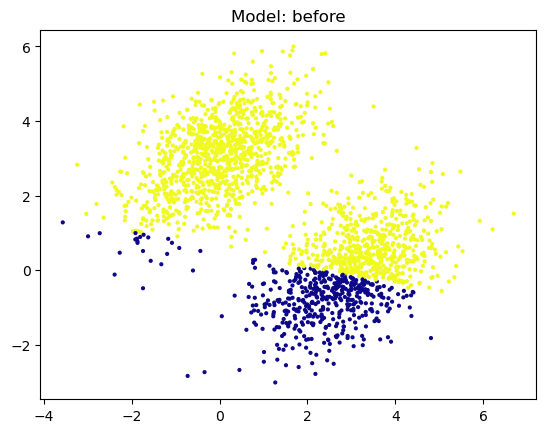

In [34]:
predictions = model(inputs, W, b)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.title("Model: before")
plt.show()

In [35]:
for step in range(40):
    loss = training_step(inputs, targets, W, b)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 4.6876
Loss at step 1: 0.4376
Loss at step 2: 0.1668
Loss at step 3: 0.1236
Loss at step 4: 0.1109
Loss at step 5: 0.1028
Loss at step 6: 0.0959
Loss at step 7: 0.0897
Loss at step 8: 0.0840
Loss at step 9: 0.0788
Loss at step 10: 0.0741
Loss at step 11: 0.0698
Loss at step 12: 0.0659
Loss at step 13: 0.0623
Loss at step 14: 0.0590
Loss at step 15: 0.0561
Loss at step 16: 0.0533
Loss at step 17: 0.0509
Loss at step 18: 0.0486
Loss at step 19: 0.0466
Loss at step 20: 0.0447
Loss at step 21: 0.0430
Loss at step 22: 0.0414
Loss at step 23: 0.0400
Loss at step 24: 0.0387
Loss at step 25: 0.0375
Loss at step 26: 0.0364
Loss at step 27: 0.0354
Loss at step 28: 0.0345
Loss at step 29: 0.0337
Loss at step 30: 0.0330
Loss at step 31: 0.0323
Loss at step 32: 0.0317
Loss at step 33: 0.0311
Loss at step 34: 0.0306
Loss at step 35: 0.0301
Loss at step 36: 0.0297
Loss at step 37: 0.0293
Loss at step 38: 0.0289
Loss at step 39: 0.0286


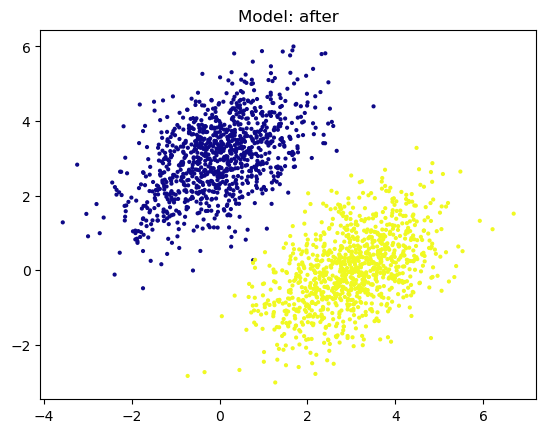

In [36]:
predictions = model(inputs, W, b)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.title("Model: after")
plt.show()

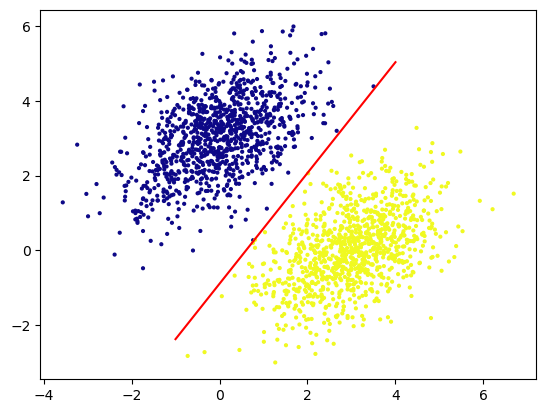

In [37]:
x = np.linspace(-1, 4, 100) # a bunch of points
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r") # this is the separation line the model learns
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

#### Visualisation

In [38]:
learning_rate = 0.05
import time

def training_step_with_plot(inputs, targets, step, W, b, plot=False):
    # we will learn about the gradient: this is how the model knows how to change
    # in order to improve itself!
    with tf.GradientTape() as tape:
        predictions = model(inputs, W, b)
        loss = square_loss(targets, predictions)
        # -----------------------------------
        # optional plotting
        if plot:
            x = np.linspace(-1, 4, 100)          
            y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
            plt.plot(x, y, "-r")
            # just to make sure our plots remain the same size
            plt.xlim([-4, 7])
            plt.ylim([-4, 7])
            plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
            plt.title(f"Loss at step {step}: {loss}")
            plt.text(-3.9, 6.5, f"W: {W.numpy().ravel()}")
            plt.text(-3.9, 6, f"b:  {b.numpy()}")
            plt.show()
        # -----------------------------------            
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

In [39]:
# reinitialise our variables
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

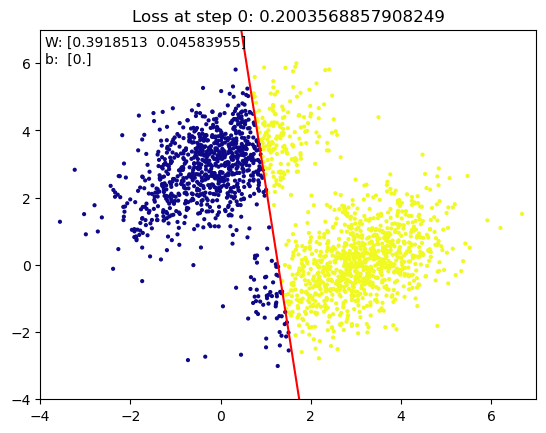

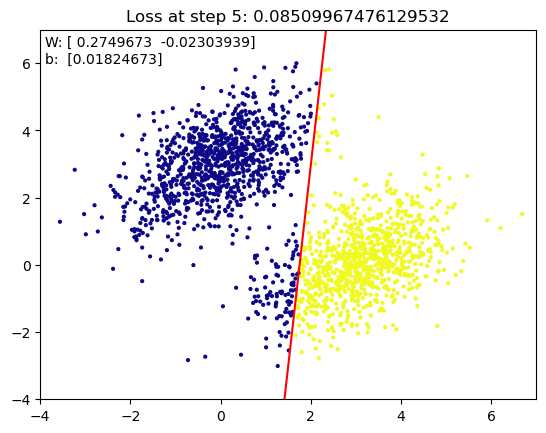

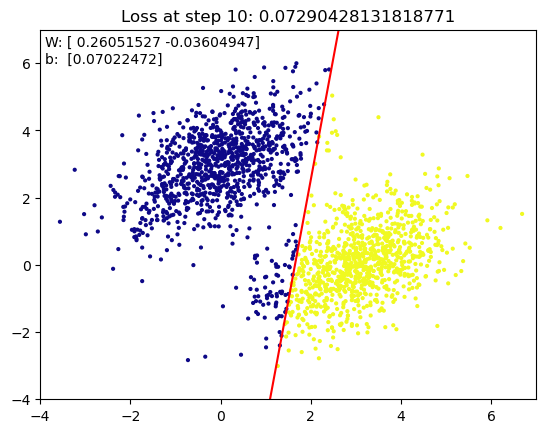

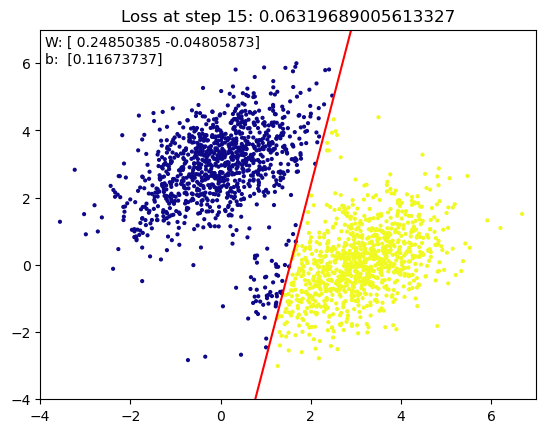

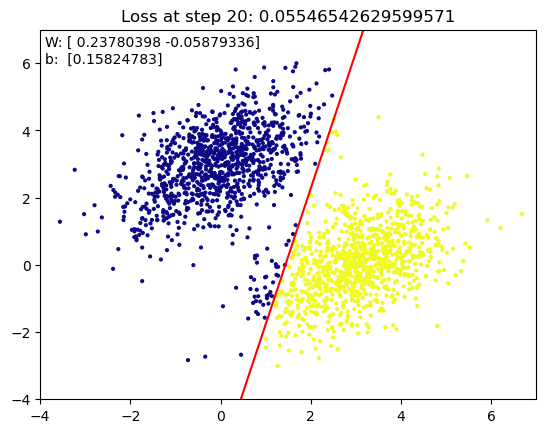

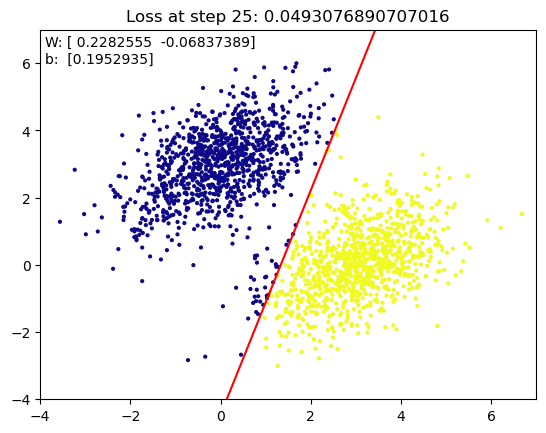

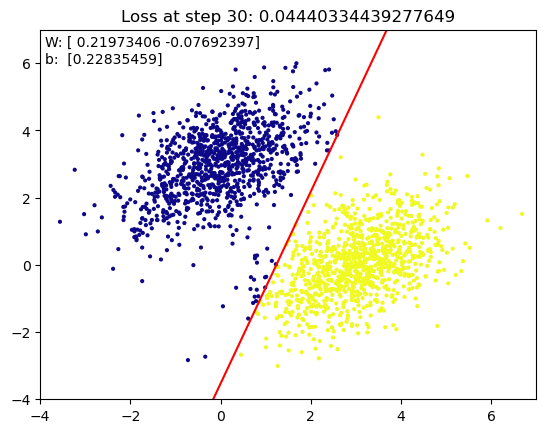

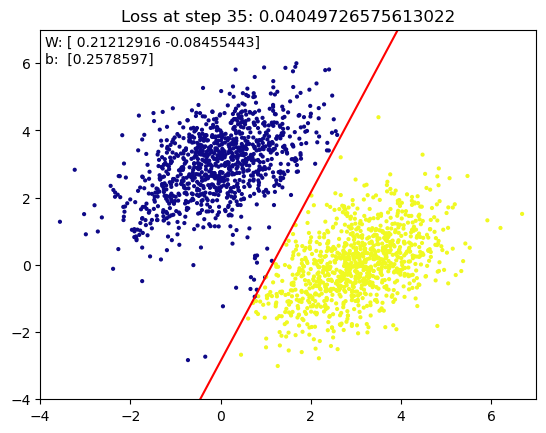

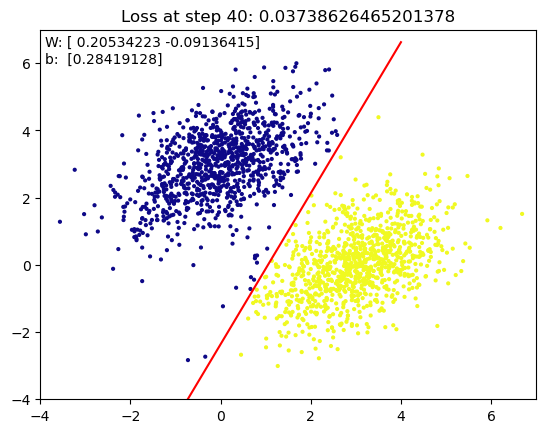

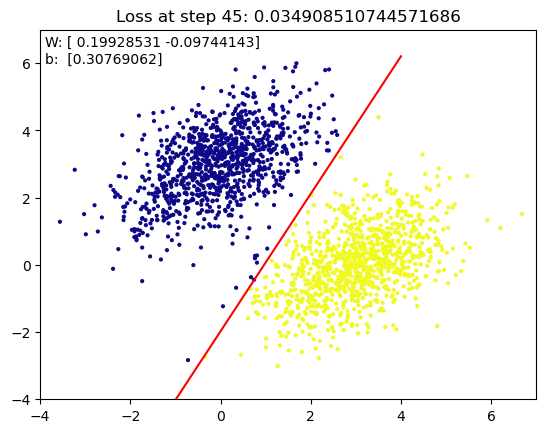

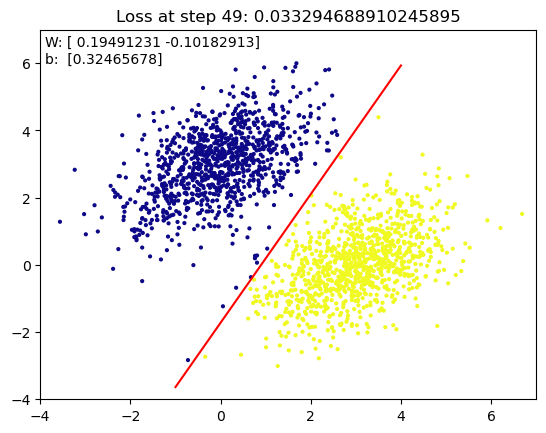

ground truth:


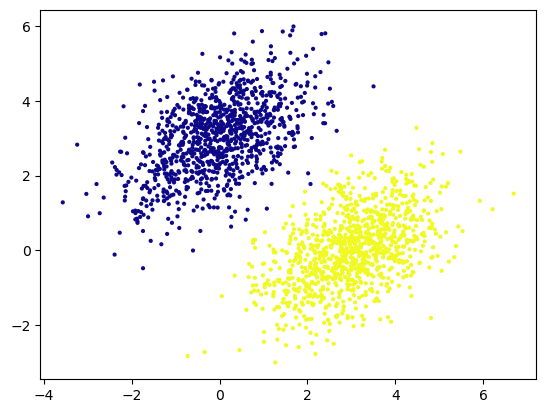

In [41]:
epochs = 50
for step in range(epochs):
    # every five step we will plot our progress
    plot = False
    if step % 5 == 0 or step == epochs - 1:
        plot = True
    loss = training_step_with_plot(inputs, targets, step, W, b, plot=plot)
    time.sleep(.5)
  
# compare with our actual data
print("=" * 80)
print("ground truth:")
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

### What makes the TensorFlow approach unique

Main benefits of TensorFlow:

- Thanks to graph mode and XLA compilation, it’s fast (often faster than PyTorch and NumPy, though JAX is often even faster).
- It is extremely feature complete, and has outstanding support for data preprocessing (`tf.data`).
- Its ecosystem for production deployment is the most mature among all frameworks, especially when it comes to deploying on mobile or in the browser.

Some flaws:

- It has a sprawling API — the flipside of being very feature complete.
- Its numerical API is occasionally inconsistent with the NumPy API.
- The popular pretrained model-sharing platform Hugging Face has less support for TensorFlow.

## Introduction to PyTorch

Developed primarily by Meta (formerly Facebook), originally released in September 2016 (as a response to the release of TensorFlow). PyTorch follows an object-oriented philosophy, the success of which pushed for the adoption of that in TensorFlow 2. It is used extensively in the machine learning research community.

Like TensorFlow, PyTorch is at the center of a large ecosystem of related packages, such as `torchvision`, `torchaudio`, or the popular model-sharing platform HuggingFace.

In [42]:
import torch

### First steps with PyTorch

Key concepts:

- Tensors and parameters
- Numerical operations in PyTorch
- Computing gradients with the `backward()` method
- Packaging computation with the Module class
- Speeding up PyTorch by using compilation

Note: when installing, you use `pip/mamba install torch` (not `pytorch`).

#### Tensors and parameters in PyTorch

##### Constant tensors

In [43]:
torch.ones(size=(2, 1))

tensor([[1.],
        [1.]])

In [44]:
torch.zeros(size=(2, 1))

tensor([[0.],
        [0.]])

In [45]:
torch.tensor([1, 2, 3], dtype=torch.float32)

tensor([1., 2., 3.])

##### Random tensors

In [46]:
torch.normal(
mean=torch.zeros(size=(3, 1)),
std=torch.ones(size=(3, 1)))

tensor([[ 0.7421],
        [-0.5435],
        [-1.3858]])

In [47]:
torch.rand(3, 1)

tensor([[0.4104],
        [0.0668],
        [0.6864]])

##### Tensor assignment and the Parameter class

PyTorch tensors are assignable!

In [48]:
x = torch.zeros(size=(2, 1))
x[0, 0] = 1.
x

tensor([[1.],
        [0.]])

While you can just use a regular `torch.Tensor` to store the trainable state of a model, PyTorch does provide a specialized tensor subclass for that purpose, the `torch.nn.parameter.Parameter` class. Compared to a regular tensor, it provides semantic clarity — if you see a `Parameter`, you’ll know it’s a piece of trainable state, whereas a `Tensor` could be anything. As a result, it enables PyTorch to automatically track and retrieve the `Parameters` you assign to PyTorch models — similar to what Keras does with Keras `Variable` instances.

In [49]:
x = torch.zeros(size=(2, 1))
# x must be a tensor (no numpy array)
p = torch.nn.parameter.Parameter(data=x)

#### Tensor operations: Doing math in PyTorch

In [50]:
a = torch.ones((2, 2))
b = torch.square(a)
c = torch.sqrt(a)
d = b + c
e = torch.matmul(a, b)
f = torch.cat((a, b), dim=0)

In [51]:
def dense(inputs, W, b):
    return torch.nn.relu(torch.matmul(inputs, W) + b)

#### Computing gradients with PyTorch

No gradient tape here – the process happens automatically, hidden from the user's eyes. The gradients are accessible through tensors themselves: you can call `tensor.backward()` to run backpropagation through all operations previously executed that led to that tensor. Doing this will populate the `.grad` attribute of all tensors that are tracking gradients.

In [52]:
# To compute gradients with respect to a tensor, it must be created
# with requires_grad=True.
input_var = torch.tensor(3.0, requires_grad=True)
result = torch.square(input_var)
# Calling backward() populates the "grad" attribute on all tensors
# create with requires_grad=True.
result.backward()
gradient = input_var.grad
gradient

tensor(6.)

Beware! If you call `backward()` multiple times in a row, the `.grad` attribute will “accumulate” gradients: each new call will sum the new gradient with the preexisting one.

In [53]:
result = torch.square(input_var)
# .grad will sum all gradient values from each time backward() is called.
result.backward()
# doubles to 12.
input_var.grad

tensor(12.)

To reset gradients, you can just set `.grad` to None (optimizer objects have a `.zero_grad()` method that does that for you):

In [ ]:
input_var.grad = None

### An end-to-end example: A linear classifier in pure PyTorch

In [54]:
input_dim = 2
output_dim = 1

W = torch.rand(input_dim, output_dim, requires_grad=True)
b = torch.zeros(output_dim, requires_grad=True)

In [55]:
def model(inputs, W, b):
    return torch.matmul(inputs, W) + b

In [56]:
def mean_squared_error(targets, predictions):
    per_sample_losses = torch.square(targets - predictions)
    return torch.mean(per_sample_losses)

In [57]:
learning_rate = 0.1

def training_step(inputs, targets, W, b):
    # 1. Forward pass
    predictions = model(inputs)
    # 2. Compute loss
    loss = mean_squared_error(targets, predictions)
    # 3. Backward pass: Computes gradients
    loss.backward()
    # 4. Retrieve gradients and update (gradient descent)
    grad_loss_wrt_W, grad_loss_wrt_b = W.grad, b.grad
    # this scope means that we don't track operations for learning
    with torch.no_grad():
        W -= grad_loss_wrt_W * learning_rate
        b -= grad_loss_wrt_b * learning_rate
    # 5. Reset gradients
    W.grad = None
    b.grad = None
    return loss

However, this is often packaged into classes to make it more usable.

#### Packaging state and computation with the Module class

To perform training more easily, PyTorch uses two main classes:
- `torch.nn.Module` (for models/layers)
- `torch.optim` for the optimizer (many available, here we use `torch.optim.SGD`)

The general idea is to define a subclass of `torch.nn.Module`, which will:

- Hold some `Parameters`, to store state variables. Those are defined in the `__init__()` method.
- Implement the forward pass computation in the `forward()` method.

In [58]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.W = torch.nn.Parameter(torch.rand(input_dim, output_dim))
        self.b = torch.nn.Parameter(torch.zeros(output_dim))

    def forward(self, inputs):
        return torch.matmul(inputs, self.W) + self.b

In [59]:
model = LinearModel()

In [60]:
torch_inputs = torch.tensor(inputs)
# calling the model will use forward() under the hood
output = model(torch_inputs)

Now, to update the parameters, you instantiate an optimizer object, and pass it the model parameters.

In [61]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Our training step is now simpler.

In [63]:
def training_step(inputs, targets):
    # 1. Forward pass
    predictions = model(inputs)
    # 2. Compute loss
    loss = mean_squared_error(targets, predictions)
    # 3. Backward pass: Computes gradients
    loss.backward()
    # 4. Retrieve gradients and update (gradient descent)
    optimizer.step()
    # 5. Reset gradients
    model.zero_grad()
    return loss

#### Making PyTorch modules fast using compilation

Similar to `@tf.function`.

In [64]:
compiled_model = torch.compile(model)

In [ ]:
# also available as a decorator
@torch.compile
def dense(inputs, W, b):
    return torch.nn.relu(torch.matmul(inputs, W) + b)

### What makes the PyTorch approach unique

Key strengths:

- PyTorch code executes eagerly by default, making it easy to debug.
- The popular pretrained model-sharing platform HuggingFace has first-class support for PyTorch, which means that any model you’d like to use is likely available in PyTorch.

Meanwhile, there are also some downsides to using PyTorch:

- Like with TensorFlow, the PyTorch API is inconsistent with NumPy. Further, it’s also internally inconsistent (for instance, the commonly used keyword axis is occasionally named dim instead, depending on the function).
- Due to its focus on eager execution, PyTorch can be quite slow.
- While it is possible to make PyTorch code faster via `torch.compile()`, this isn't yet fully ironed out. As a result, only a very small percentage of the PyTorch user base uses compilation.

## Introduction to JAX

JAX is the latest framework to have been developed, and is used by many top companies (DeepMind, etc.).

JAX embraces a *stateless* approach to computation (functional), meaning that functions in JAX **do not maintain any persistent state**. 

The stateless nature of JAX functions has several advantages. In particular, it enables effective automatic parallelization and distributed computation, as functions can be executed independently without the need for synchronization. This makes scalability easier, although it comes with an some learning curve and quite a few sharp edges.

In [65]:
import jax
from jax import numpy as jnp

### First steps with JAX

Key concepts:

- The array class
- Random operations in JAX
- Numerical operations in JAX
- Computing gradients via `jax.grad` and `jax.value_and_grad`
- Making JAX functions fast by leveraging just-in-time compilation

### Tensors in JAX

The API is fully consistent with NumPy!

In [66]:
jnp.ones(shape=(2, 1))

Array([[1.],
       [1.]], dtype=float32)

In [67]:
jnp.zeros(shape=(2, 1))

Array([[0.],
       [0.]], dtype=float32)

In [68]:
jnp.array([1, 2, 3], dtype="float32")

Array([1., 2., 3.], dtype=float32)

There are however two differences with NumPy: random number generation and array assignment.

### Random number generation in JAX

JAX is *stateless*, which implies that JAX code can’t rely on any hidden global state, which will have an impact on all “PRNG” (Pseudo-Random Number Generation) operations. In NumPy, such a thing is used when dealing with random numbers.

In [69]:
np.random.normal(size=(3,))

array([ 0.32102802, -0.50685301, -1.6833898 ])

In [70]:
# the global state has changed, therefore this
# call produces different numbers
np.random.normal(size=(3,))

array([ 0.0701295 , -0.36518692,  0.54541006])

In JAX, the same API call must always return the same value. That means that you need to handle the state (or seed) yourself.

In [75]:
def apply_noise(x, seed):
    np.random.seed(seed)
    x = x * np.random.normal(size=(3,))
    return x

x = np.ones((3,))
print(x)
seed = 1337
y = apply_noise(x, seed)
print(y)
seed += 1
z = apply_noise(x, seed)
print(z)

[1. 1. 1.]
[-0.70318731 -0.49028236 -0.32181433]
[ 0.30339572  0.06905289 -1.36994721]


Same in JAX, however, JAX doesn’t use integer seeds. It uses special array structures called *keys*.

In [76]:
seed_key = jax.random.key(1337)

To force you to always provide a seed “key” to PRNG calls, all JAX PRNG-using operations take key (the random seed) as their first positional argument.

In [77]:
seed_key = jax.random.key(0)
jax.random.normal(seed_key, shape=(3,))

Array([ 1.6226422 ,  2.0252647 , -0.43359444], dtype=float32)

In [78]:
seed_key = jax.random.key(123)

# pass the same key -> get the same result
print(jax.random.normal(seed_key, shape=(3,)))
print(jax.random.normal(seed_key, shape=(3,)))

[1.6359469  0.8408094  0.02212393]
[1.6359469  0.8408094  0.02212393]


If you need a new seed key, you can simply create a new one from an existing one using the `jax.random.split()` function. It is deterministic, so the same sequence of splits will always result in the same final seed key.

In [80]:
#  You could even split your key into multiple new keys at once!
new_seed_key = jax.random.split(seed_key, num=1)[0]
jax.random.normal(new_seed_key, shape=(3,))

Array([-0.49093357, -0.9478693 , -1.775197  ], dtype=float32)

This makes your code vectorizable (i.e., the JAX compiler can automatically turn it into highly parallel code) while maintaining determinism (i.e., you can run the same code twice with the same results). Not possible with a global PRNG state!

#### Tensor assignment

JAX arrays are not assignable in place. Instead, if you need to update a tensor, you must create a new tensor with the desired value. JAX makes this easy by providing the `at()`/`set()` API.

In [81]:
x = jnp.array([1, 2, 3], dtype="float32")
new_x = x.at[0].set(10)

#### Tensor operations: Doing math in JAX

In [82]:
a = jnp.ones((2, 2))
b = jnp.square(a)
c = jnp.sqrt(a)
d = b + c
e = jnp.matmul(a, b)
e *= d

In [83]:
def dense(inputs, W, b):
    return jax.nn.relu(jnp.matmul(inputs, W) + b)

#### Computing gradients with JAX

Unlike TensorFlow and PyTorch, JAX takes a *metaprogramming* approach to gradient computation. Metaprogramming refers to the idea of having * (unctions that return functions* (“meta-functions”). In practice, JAX lets you turn a *loss-computation* function into a *gradient-computation* function. So computing gradients in JAX is a three-step process:

- Define a loss function, `compute_loss()`.
- Call `grad_fn = jax.grad(compute_loss)` to retrieve a gradient-computation function.
- Call `grad_fn` to retrieve the gradient values.

The loss function should verify the following properties:

- It should return a scalar loss value.
- Its first argument (which, in the following example, is also the only argument) should contain the state arrays we need gradients for (usually named `state`, which could be a single array, a list of arrays, or a dict of arrays).

In [86]:
def compute_loss(input_var):
    return jnp.square(input_var)

Create a gradient-computation function – taking the same arguments as the original loss function, but returning the gradient of the loss with respect to `input_var`.

In [87]:
grad_fn = jax.grad(compute_loss)

Once you’ve obtained `grad_fn()`, you can call it with the same arguments as `compute_loss()`, and it will return gradients arrays corresponding to the first argument of `compute_loss()`. In our case, our first argument was a single array, so `grad_fn()` directly returns the gradient of the loss with respect to that one array

In [89]:
input_var = jnp.array(3.0)
grad_of_loss_wrt_input_var = grad_fn(input_var)
grad_of_loss_wrt_input_var

Array(6., dtype=float32, weak_type=True)

#### JAX gradient-computation best practices

##### Returning the loss value

It would be quite inefficient to recompute it independently outside of `grad_fn()`, so instead, you can just configure your `grad_fn()` to also return the loss value. This is done by using the JAX utility `jax.value_and_grad()` instead of `jax.grad()`. 

In [90]:
grad_fn = jax.value_and_grad(compute_loss)
output, grad_of_loss_wrt_input_var = grad_fn(input_var)
output, grad_of_loss_wrt_input_var

(Array(9., dtype=float32, weak_type=True),
 Array(6., dtype=float32, weak_type=True))

##### Getting gradients for a complex function

And what if your `compute_loss()` function has more than one input?

Let’s say your state contains three variables, `a`, `b`, and `c`, and your loss function has two inputs, `x` and `y`. Here's how you'd structure it:

```python
# state contains a, b, and c. It must be the first argument.
def compute_loss(state, x, y):
    ...
    return loss

grad_fn = jax.value_and_grad(compute_loss)
state = (a, b, c)
# grads_of_loss_wrt_state has the same structure as state.
loss, grads_of_loss_wrt_state = grad_fn(state, x, y)
```

`state` could be a dict, list, or nested structures of those (JAX call these nested structures *trees*).

##### Returning auxiliary outputs

Finally, what if your `compute_loss()` function needs to return more than just the loss?

Use the `has_aux` argument:

- Edit the loss function to return a tuple where the first entry is the loss, and the second entry is your extra output.
- Pass the argument `has_aux=True` to `value_and_grad()`. This tells `value_and_grad()` to return not just the gradient but also the “auxiliary” output(s) of `compute_loss()`:

```python
def compute_loss(state, x, y):
    ...
    # Returns a tuple
    return loss, output

# Passes has_aux=True here
grad_fn = jax.value_and_grad(compute_loss, has_aux=True)
# Gets back a nested tuple
loss, (grads_of_loss_wrt_state, output) = grad_fn(state, x, y)
```

#### Making JAX functions fast with @jax.jit

Equivalent to `@tf.function(jit_compile=True)`, and turns any stateless JAX function into an XLA-compiled piece of code, typically delivering a considerable execution speedup.

In [ ]:
@jax.jit
def dense(inputs, W, b):
    return jax.nn.relu(jnp.matmul(inputs, W) + b)

Beware! You can only decorate a stateless function — any tensors that get updated by the function should be part of its return values

### An end-to-end example: A linear classifier in pure JAX

- All functions we will create will be stateless. That means the state (the arrays `W` and `b`) will be provided as function arguments, and if they get modified by the function, their new value will be returned by the function.
- Gradients are computed using the JAX `value_and_grad()` utility.


In [91]:
def model(inputs, W, b):
    return jnp.matmul(inputs, W) + b

def mean_squared_error(targets, predictions):
    per_sample_losses = jnp.square(targets - predictions)
    return jnp.mean(per_sample_losses)

In [92]:
def compute_loss(state, inputs, targets):
    W, b = state
    predictions = model(inputs, W, b)
    loss = mean_squared_error(targets, predictions)
    return loss

In [93]:
# our grad function
grad_fn = jax.value_and_grad(compute_loss)

In [94]:
learning_rate = 0.1

# We use the jax.jit decorator to take advantage of XLA compilation.
@jax.jit
def training_step(inputs, targets, W, b):
    # Computes the forward pass and backward pass in one go
    loss, grads = grad_fn((W, b), inputs, targets)
    grad_wrt_W, grad_wrt_b = grads
    # Updates W and b
    W = W - grad_wrt_W * learning_rate
    b = b - grad_wrt_b * learning_rate
    # Return the new values of W and b in addition to the loss!
    return loss, W, b

If you wanted to modify your learning rate during training, you'd need to include it in the state.

In [95]:
input_dim = 2
output_dim = 1

W = jax.numpy.array(np.random.uniform(size=(input_dim, output_dim)))
b = jax.numpy.array(np.zeros(shape=(output_dim,)))
state = (W, b)
for step in range(40):
    loss, W, b = training_step(inputs, targets, W, b)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 3.8252
Loss at step 1: 0.4183
Loss at step 2: 0.1631
Loss at step 3: 0.1220
Loss at step 4: 0.1097
Loss at step 5: 0.1017
Loss at step 6: 0.0949
Loss at step 7: 0.0888
Loss at step 8: 0.0832
Loss at step 9: 0.0781
Loss at step 10: 0.0734
Loss at step 11: 0.0692
Loss at step 12: 0.0653
Loss at step 13: 0.0618
Loss at step 14: 0.0586
Loss at step 15: 0.0556
Loss at step 16: 0.0530
Loss at step 17: 0.0505
Loss at step 18: 0.0483
Loss at step 19: 0.0463
Loss at step 20: 0.0444
Loss at step 21: 0.0427
Loss at step 22: 0.0412
Loss at step 23: 0.0398
Loss at step 24: 0.0385
Loss at step 25: 0.0373
Loss at step 26: 0.0363
Loss at step 27: 0.0353
Loss at step 28: 0.0344
Loss at step 29: 0.0336
Loss at step 30: 0.0329
Loss at step 31: 0.0322
Loss at step 32: 0.0316
Loss at step 33: 0.0310
Loss at step 34: 0.0305
Loss at step 35: 0.0300
Loss at step 36: 0.0296
Loss at step 37: 0.0292
Loss at step 38: 0.0289
Loss at step 39: 0.0286


### What makes the JAX approach unique

The main thing that makes JAX unique among modern machine learning frameworks is its functional, stateless philosophy. 

Strong points:

- It’s fast (for most models, it is the fastest).
- Fully consistent with NumPy.
- It’s the best fit for training models on TPUs.

Hurdles:

- Its use of metaprogramming and compilation can make it significantly harder to debug compared to pure eager execution.
- Low-level training loops tend to be more verbose and more difficult to write .

## Introduction to Keras

From the beginning, Keras was meant to be a higher-level API allowing for faster and easier model development. However, enables a wide range of different workflows, from the very high-level to the very low-level, corresponding to different user profiles. See Chapter 7 for details.

### First steps with Keras

Keras can be used together with JAX, TensorFlow, or PyTorch – the “backend frameworks”. Through these backend frameworks, Keras can run on top of different types of hardware — GPU, TPU, or plain CPU — and scaled up if needed.

<!-- ![A figure showing the Keras library interacting with lower-level Deep Learning libraries like PyTorch, TensorFlow or JAX, themselves interacting with the hardware](images/chollet/figure3.4.png) -->

![A figure showing the Keras library interacting with lower-level Deep Learning libraries like PyTorch, TensorFlow or JAX, themselves interacting with the hardware](https://raw.githubusercontent.com/jchwenger/DLWP/main/lectures/01.more/images/chollet/figure3.4.png)

[DLWP](https://deeplearningwithpython.io/chapters/chapter03_introduction-to-ml-frameworks/#picking-a-backend-framework), Chapter 3, figure 3.4

Note that the same Keras code can be run with different backends at any point!

#### Picking a backend framework

To set the environment, either set the environment variable `KERAS_BACKEND` in a terminal (`export KERAS_BACKEND=jax`). Or do it in Python (before importing `keras`). Note that the default is `"tensorflow"`.

In [ ]:
os.environ["KERAS_BACKEND"] = "jax" # or "tensorflow", "torch"

import keras

### Layers: The building blocks of deep learning

A layer is a data processing module that takes as input one or more tensors and that outputs one or more tensors. Some layers are stateless, but more frequently layers have a state: the layer’s `weights`. See [the documentation](https://keras.io/api/layers/) to see the many available options.

#### The base `Layer` class in Keras

A `Layer` is an object that encapsulates some state (weights) and some computation (a forward pass). The weights are typically defined in a `build()` (although they could also be created in the constructor `__init__()`), and the computation is defined in the `call()` method.

In [96]:
# All Keras layers inherit from the base Layer class.
class SimpleDense(keras.Layer):
    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    # Weight creation takes place in the build() method.
    def build(self, input_shape):
        batch_dim, input_dim = input_shape
        # add_weight is a shortcut method for creating weights. It's
        # also possible to create standalone variables and assign them
        # as layer attributes, like self.W = keras.Variable(shape=...,
        # initializer=...).
        self.W = self.add_weight(
            shape=(input_dim, self.units), initializer="random_normal"
        )
        self.b = self.add_weight(shape=(self.units,), initializer="zeros")

    # We define the forward pass computation in the call() method.
    def call(self, inputs):
        y = keras.ops.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

In [97]:
my_dense = SimpleDense(units=32, activation=keras.ops.relu)
input_tensor = keras.ops.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


#### Automatic shape inference: Building layers on the fly

The great things about layers is that you can stack them together, provided that they are *compatible* (i.e. that the output of one is accepted by as input by the next).

The following layers returns a tensor with non-batch dimension of `32`.

In [ ]:
layer = keras.layers.Dense(32, activation="relu")

The second layer automatically infers that its input will be of shape `32`.

In [ ]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(32),
    ]
)

This is of course very practical, but some users prefer to have something more explicit, not to lose track of the shapes of the intermediate computation (however that leads to more verbose code, often seen in PyTorch models). For example:
```python
model = NaiveSequential(
    [
        NaiveDense(input_size=784, output_size=32, activation="relu"),
        NaiveDense(input_size=32, output_size=64, activation="relu"),
        NaiveDense(input_size=64, output_size=32, activation="relu"),
        NaiveDense(input_size=32, output_size=10, activation="softmax"),
    ]
)
```

In the Keras `SimpleDense`, we don't create weights in the constructor. Instead, we create them in a dedicated state-creation method `build()`, which receives as argument the first input shape seen by the layer. The `build()` method is called automatically the first time the layer is called (via its `__call__()` method). Schematically:

```python
def __call__(self, inputs):
    if not self.built:
        self.build(inputs.shape)
        self.built = True
    return self.call(inputs)
```

That leads to the following neat code:

In [ ]:
model = keras.Sequential(
    [
        SimpleDense(32, activation="relu"),
        SimpleDense(64, activation="relu"),
        SimpleDense(32, activation="relu"),
        SimpleDense(10, activation="softmax"),
    ]
)

### From layers to models

A deep learning model is a graph of layers. In Keras, that’s the `Model` class. For now, youwe’ve only seen `Sequential` models, which are simple stacks of layers (single input, single output). But there exists of course a  much broader variety of network topologies, like:

- Two-branch networks
- Multihead networks
- Residual connections
  
The details of this are seen in chapter 7.

The topology of a model defines a *hypothesis space*. By choosing a network topology, you constrain your space of possibilities (hypothesis space) to a specific series of tensor operations, mapping input data to output data. What you’ll then be searching for is a good set of values for the weight tensors involved in these tensor operations.

To learn from data, you have to make assumptions about it. These assumptions define what can be learned. As such, the structure of your hypothesis space — the architecture of your model — is extremely important. It encodes the assumptions you make about your problem, the prior knowledge that the model starts with. For instance, if you’re working on a two-class classification problem with a model made of a single Dense layer with no activation (a pure affine transformation), you are assuming that your two classes are linearly separable.

Picking the right network architecture is more an art than a science, and although there are some best practices and principles you can rely on, only practice can help you become a proper neural network architect.

### The "compile" step: Configuring the learning process

Once the model architecture is defined, you still have to choose three more things:

- *Loss function (objective function)* — The quantity that will be minimized during training. It represents a measure of success.
- *Optimizer* — Determines how the network will be updated based on the loss function (a variant of stochastic gradient descent (SGD)).
- *Metrics*— The measures of success you want to monitor during training and validation, such as classification accuracy. Unlike the loss, training will not optimize directly for these metrics (so they don’t need to be differentiable).

Once you’ve picked your loss, optimizer, and metrics, you can use the built-in `compile()` and `fit()` methods to start training your model (custom training loops are also in chapter 7).

In [98]:
# Defines a linear classifier
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(
    # Specifies the optimizer by name: RMSprop (it's case-insensitive) 
    optimizer="rmsprop",
    # Specifies the loss by name: mean squared error
    loss="mean_squared_error",
    # Specifies a list of metrics: in this case, only accuracy
    metrics=["accuracy"],
)

The above is equivalent to passing objects (which can be customised).

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

Have a look at the documentation for:

- [Optimizers](https://keras.io/api/optimizers/)
- [Losses](https://keras.io/api/losses/)
- [Metrics](https://keras.io/api/metrics/)

### Picking a loss function

Choosing the right loss function for the right problem is extremely important: your network will take any shortcut it can to minimize the loss. So if the objective doesn’t fully correlate with success for the task at hand, your network will end up doing things you may not have wanted. Imagine a stupid, omnipotent AI trained via SGD, with this poorly chosen objective function: “Maximize the average well-being of all humans alive.” To make its job easier, this AI might choose to kill all humans except a few and focus on the well-being of the remaining ones because average well-being isn’t affected by how many humans are left. That might not be what you intended! Just remember that all neural networks you build will be just as ruthless in lowering their loss function, so choose the objective wisely, or you’ll have to face unintended side effects.

Fortunately, when it comes to common problems such as classification, regression, and sequence prediction, there are simple guidelines you can follow to choose the correct loss (binary crossentropy for a two-class classification problem, categorical crossentropy for a many-class classification problem, etc).

### Understanding the fit method

In [99]:
history = model.fit(
    # The input examples, as a NumPy array
    inputs,
    # The corresponding training targets, as a NumPy array
    targets,
    # The training loop will iterate over the data 5 times.
    epochs=5,
    # The training loop will iterate over the data in batches of 128 examples.
    batch_size=128,
)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9980 - loss: 4.0113
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - accuracy: 0.9980 - loss: 3.7817
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - accuracy: 0.9980 - loss: 3.5888
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - accuracy: 0.9980 - loss: 3.4043
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - accuracy: 0.9980 - loss: 3.2252


In [100]:
history.history

{'accuracy': [0.9980000257492065,
  0.9980000257492065,
  0.9980000257492065,
  0.9980000257492065,
  0.9980000257492065],
 'loss': [4.011287212371826,
  3.7817485332489014,
  3.588848829269409,
  3.4042937755584717,
  3.2252042293548584]}

### Monitoring loss and metrics on validation data

The goal of machine learning is not to obtain models that perform well on the training data, which is easy — all you have to do is follow the gradient. The goal is to obtain models that perform well in general, particularly on data points that the model has never encountered before. Just because a model performs well on its training data doesn’t mean it will perform well on data it has never seen! For instance, it’s possible that your model could end up merely *memorizing* a mapping between your training samples and their targets, which would be useless for the task of predicting targets for data the model has never seen before.

To keep an eye on how the model does on new data, it’s standard practice to reserve a subset of the training data as “validation data”: you won’t be training the model on this data, but you will use it to compute a loss value and metrics value. You do this by using the `validation_data` argument in `fit()`. Like the training data, the validation data could be passed as NumPy arrays or as a TensorFlow `Dataset` object.

In [102]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

# To avoid having samples from only one class in the validation data,
# shuffle the inputs and targets using a random indices permutation
indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

# Reserve 30% of the training inputs and targets for validation.
# (We'll exclude these samples from training and reserve them to
# compute the validation loss and metrics.)
num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    # Training data, used to update the weights of the model
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    # Validation data, used only to monitor the validation loss and metrics
    validation_data=(val_inputs, val_targets),
)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9164 - loss: 0.2388 - val_binary_accuracy: 0.9900 - val_loss: 0.0455
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - binary_accuracy: 0.9550 - loss: 0.0728 - val_binary_accuracy: 0.5650 - val_loss: 0.3658
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - binary_accuracy: 0.9471 - loss: 0.0756 - val_binary_accuracy: 0.6933 - val_loss: 0.1939
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - binary_accuracy: 0.9493 - loss: 0.0796 - val_binary_accuracy: 0.9983 - val_loss: 0.0285
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - binary_accuracy: 0.9543 - loss: 0.0724 - val_binary_accuracy: 0.9983 - val_loss: 0.0372


The value of the loss on the validation data is called the `validation loss`, to distinguish it from the training loss. Note that it’s essential to keep the training data and validation data strictly separate: the purpose of validation is to monitor whether what the model is learning is actually useful on new data. If any of the validation data has been seen by the model during training, your validation loss and metrics will be flawed.

If you want to compute the validation loss and metrics after training is complete, you can call the evaluate method:

In [104]:
loss_and_metrics = model.evaluate(val_inputs, val_targets, batch_size=128)
loss_and_metrics

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9983 - loss: 0.0372


[0.03723479062318802, 0.9983333349227905]

`evaluate()` will iterate in batches (of size `batch_size`) over the data passed and return a list of scalars, where the first entry is the validation loss and the following entries are the validation metrics. If the model has no metrics, only the validation loss is returned (rather than a list).

### Inference: Using a model after training

Once you’ve trained your model, you’re going to want to use it to make predictions on new data. This is called inference. A naive approach is to just run the data through the model using `__call__`:

```python
# Takes a NumPy array or a tensor for your current backend and returns
# a tensor for your current backend
predictions = model(new_inputs)
```

However, you might run out of memory if you have a lot of data. Instead, you can run `predict()`, that iterates over the data in small batches.

In [105]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
[[0.9771291 ]
 [0.22370899]
 [1.0901344 ]
 [0.16549039]
 [1.0094618 ]
 [0.15865293]
 [1.0121691 ]
 [0.99318564]
 [1.453222  ]
 [0.07558188]]


## Summary


- TensorFlow, PyTorch, and JAX are three popular low-level frameworks for numerical computation and autodifferentiation. They all have their own way of doing things and their own strengths and weaknesses.
- Keras is a high-level API for building and training neural networks. It can be used with either TensorFlow, PyTorch, or JAX — just pick the backend you like best.
- The central class of Keras is the `Layer`. A layer encapsulates some weights and some computation. Layers are assembled into models.
- Before you start training a model, you need to pick an optimizer, a loss, and some metrics, which you specify via the `model.compile()` method.
- To train a model, you can use the `fit()` method, which runs mini-batch gradient descent for you. You can also use it to monitor your loss and metrics on validation data, a set of inputs that the model doesn’t see during training.
- Once your model is trained, you can use the `model.predict()` method to generate predictions on new inputs.
